<a href="https://colab.research.google.com/github/Consmart18/Debiasing-Student-Algorithms/blob/main/RQ1_Examining_Fairness_as_Attribute_of_Data_Sources.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research: Debiasing Algorithms for Student Progress Monitoring
### RQ 1: Examining Fairness as an Attribute of the Data Source

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
projectdata_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project files/studentinfo_120.csv')

In [ ]:
projectdata_df.head(2)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,score_tma1,score_tma2,score_tma3,score_tma4,late_submission,sum_interaction_30,sum_interaction_60,sum_interaction_90,sum_interaction_120,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,78.0,85.0,0.0,80.0,on-time,419.0,110.0,58.0,41.0,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,70.0,68.0,0.0,70.0,late,618.0,51.0,148.0,87.0,Pass


### Data Pre-processing

In [ ]:
# drop identifiers
df = projectdata_df.drop(['code_module', 'code_presentation', 'id_student', 'late_submission'], axis=1)

In [ ]:
# fill missing values in imd_band and convert to label
mapping = {'0-10%': 1, '10-20%': 2, '20-30%': 3, '30-40%': 4, '40-50%': 5,
           '50-60%': 6, '60-70%': 7, '70-80%': 8, '80-90%': 9, '90-100%': 10}
df['imd_band'] = df['imd_band'].map(mapping)

# fill missing values with mode
df['imd_band'].fillna(df['imd_band'].mode()[0], inplace=True)

# convert age_band to label as well
mapping = {'0-35': 0, '35-55': 1, '55<=': 1}
df['age_band'] = df['age_band'].map(mapping)

In [ ]:
# Change gender and disability to binary

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['disability'] = le.fit_transform(df['disability'])

In [ ]:
# one-hot encode region, highest education, and late submission

df = pd.get_dummies(df, columns=['region'], prefix = ['Reg'])

df = pd.get_dummies(df, columns=['highest_education'], prefix = ['Edu'])

In [ ]:
# Combine pass and distinction to be 'Pass'; also combine Fail & Withdrawn to be 'At Risk'
df['final_result'] = df['final_result'].replace(['Pass', 'Distinction'], 'Pass')
df['final_result'] = df['final_result'].replace(['Fail', 'Withdrawn'], 'At Risk')
# final_result to binary
mapping = {'Pass': 0, 'At Risk': 1}
df['final_result'] = df['final_result'].map(mapping)

In [ ]:
# get a list of all the columns
cols = list(df.columns)

# move 'final_result' to the end of the list
cols.append(cols.pop(cols.index('final_result')))

# reorder the dataframe
df = df[cols]

In [ ]:
df_inst = df[['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
                         'Reg_East Anglian Region', 'Reg_East Midlands Region', 'Reg_Ireland', 'Reg_London Region',
                         'Reg_North Region', 'Reg_North Western Region', 'Reg_Scotland', 'Reg_South East Region',
                         'Reg_South Region', 'Reg_South West Region', 'Reg_Wales', 'Reg_West Midlands Region',
                         'Reg_Yorkshire Region', 'Edu_A Level or Equivalent', 'Edu_HE Qualification', 'Edu_Lower Than A Level',
                         'Edu_No Formal quals','Edu_Post Graduate Qualification','final_result']]
df_vle = df[['gender', 'age_band', 'disability', 'sum_interaction_30', 'sum_interaction_60', 'sum_interaction_90', 'sum_interaction_120', 'final_result']]
df_perf = df[['gender', 'age_band', 'disability', 'score_tma1', 'score_tma2', 'score_tma3', 'score_tma4', 'final_result']]

## Model Building

### 1. Institutional Dataset

In [ ]:
X = df_inst.drop(columns='final_result')
y = df_inst['final_result']

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

LR_score = accuracy_score(y_test, y_pred_lr)

In [ ]:
pip install holisticai

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from holisticai.bias.metrics import abroca
from holisticai.bias.plots import abroca_plot

def compute_fairness(sensitive_feature):

  # Group data by gender
  group_a = (X_test[sensitive_feature] == 1).values  # assuming 1 represents 'male'
  group_b = (X_test[sensitive_feature] == 0).values  # assuming 0 represents 'female'

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, lr.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_lr, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_lr, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

  fig, ax = plt.subplots(figsize=(8, 6))
  abroca_plot(group_a, group_b, lr.predict_proba(X_test)[:, 1], y_test, ax=ax, title='ABROCA Plot')
  plt.show()

Logistic Regression accuracy: 0.60288402536306

Gender
ABROCA value: -0.02195433167305083
Average Odds Difference value: 0.0708504264051775
Equal Opportunity Difference value: 0.04791956215900073


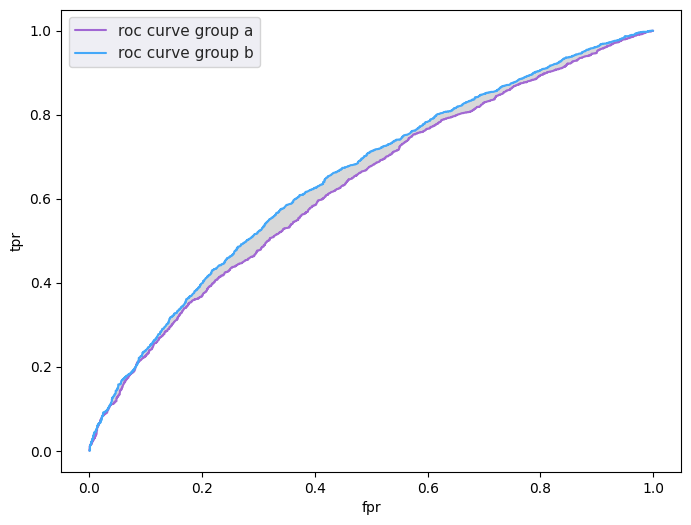


Disability
ABROCA value: 0.0253639830609369
Average Odds Difference value: 0.2736658850659256
Equal Opportunity Difference value: 0.255111805072466


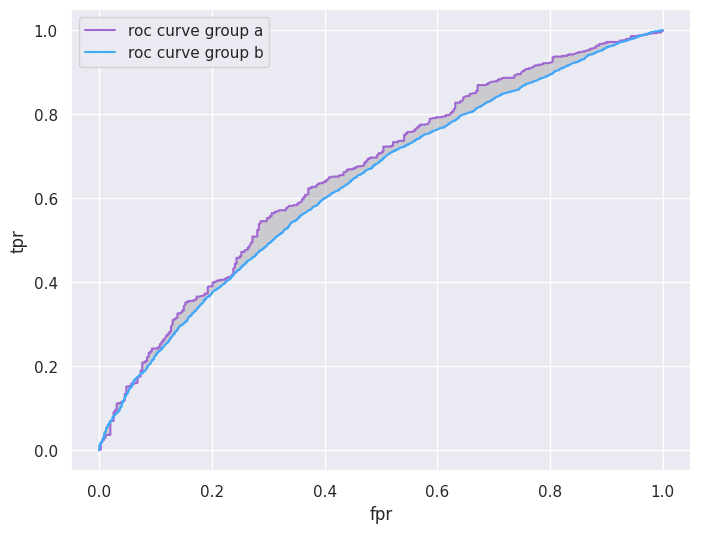


Age
ABROCA value: 0.011370795417411261
Average Odds Difference value: -0.23188721736400636
Equal Opportunity Difference value: -0.2209298180593945


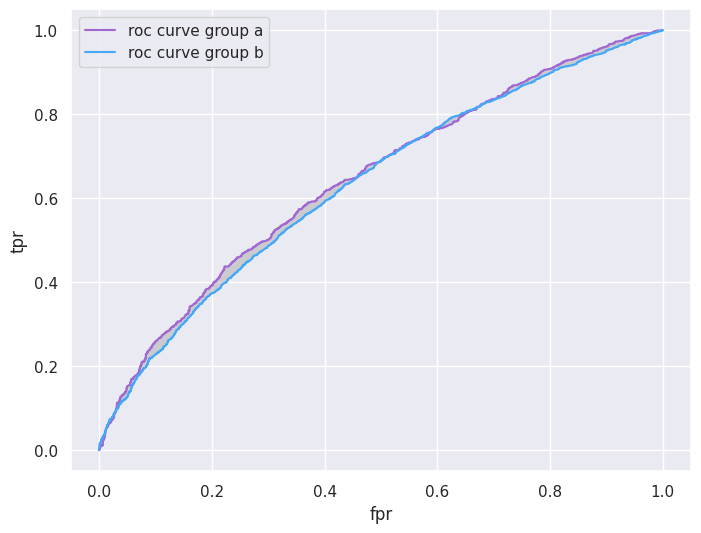

In [ ]:
# print the results for logistic regression
print('Logistic Regression accuracy:', LR_score)
print('\nGender')
compute_fairness('gender')
print(f'\nDisability')
compute_fairness('disability')
print(f'\nAge')
compute_fairness('age_band')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

GB_score = accuracy_score(y_test, y_pred_gb)

In [ ]:
def compute_fairness1(sensitive_feature):

  # Group data by gender
  group_a = (X_test[sensitive_feature] == 1).values  # assuming 1 represents 'male'
  group_b = (X_test[sensitive_feature] == 0).values  # assuming 0 represents 'female'

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, gb.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_gb, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_gb, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

  fig, ax = plt.subplots(figsize=(8, 6))
  abroca_plot(group_a, group_b, gb.predict_proba(X_test)[:, 1], y_test, ax=ax, title='ABROCA Plot')
  plt.show()

Gradient Boosting accuracy: 0.6074861934956024

Gender
ABROCA value: -0.02235633800363923
Average Odds Difference value: 0.04620970591992407
Equal Opportunity Difference value: 0.02691059935627349


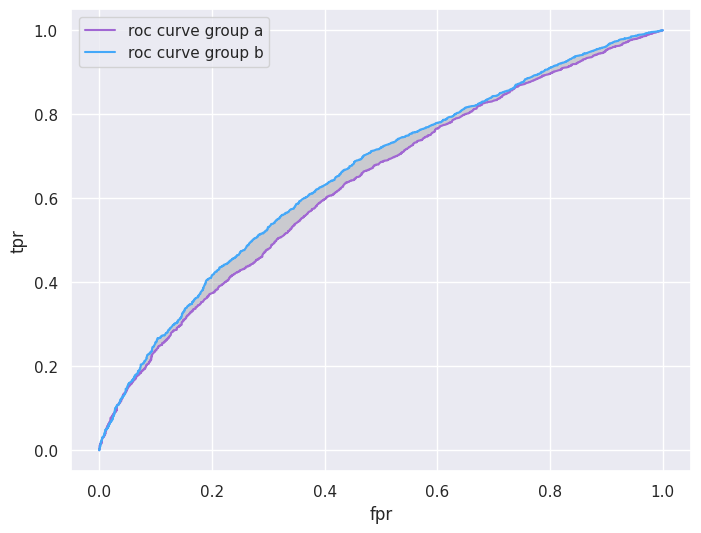


Disability
ABROCA value: 0.01969909497009259
Average Odds Difference value: 0.21242863070569135
Equal Opportunity Difference value: 0.20894379824356213


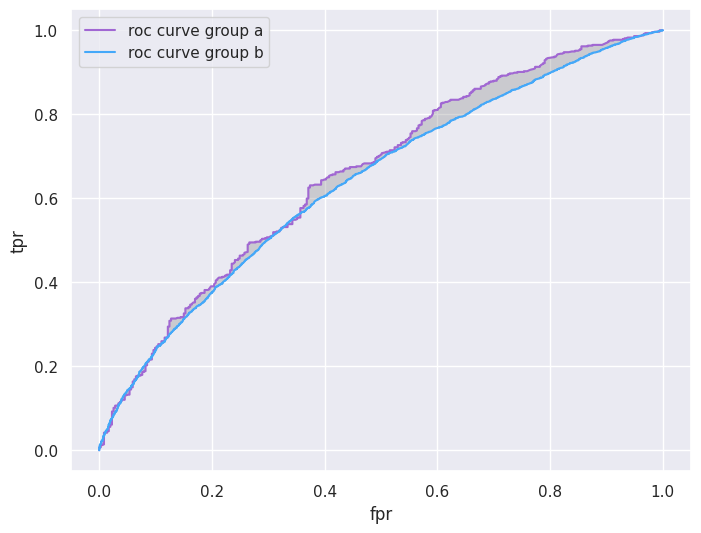


Age
ABROCA value: 0.010824943129795317
Average Odds Difference value: -0.22363370179670397
Equal Opportunity Difference value: -0.2062961087362234


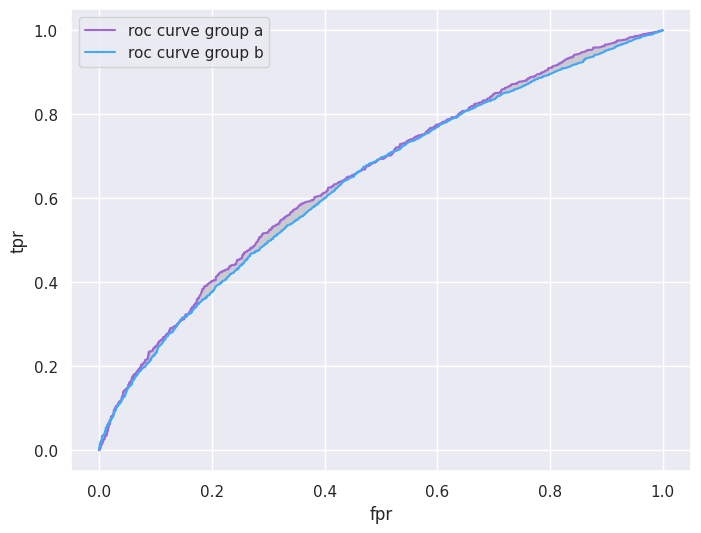

In [ ]:
# print the results for Gradient Boosting
print('Gradient Boosting accuracy:', GB_score)
print('\nGender')
compute_fairness1('gender')
print(f'\nDisability')
compute_fairness1('disability')
print(f'\nAge')
compute_fairness1('age_band')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

RF_score = accuracy_score(y_test, y_pred_rf)

In [ ]:
def compute_fairness2(sensitive_feature):

  # Group data by gender
  group_a = (X_test[sensitive_feature] == 1).values  # assuming 1 represents 'male'
  group_b = (X_test[sensitive_feature] == 0).values  # assuming 0 represents 'female'

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, rf.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_rf, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_rf, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

  fig, ax = plt.subplots(figsize=(8, 6))
  abroca_plot(group_a, group_b, rf.predict_proba(X_test)[:, 1], y_test, ax=ax, title='ABROCA Plot')
  plt.show()

Random Forest accuracy: 0.5617713233790141

Gender
ABROCA value: 0.005823502414503912
Average Odds Difference value: 0.04984604578348406
Equal Opportunity Difference value: 0.05002285994997557


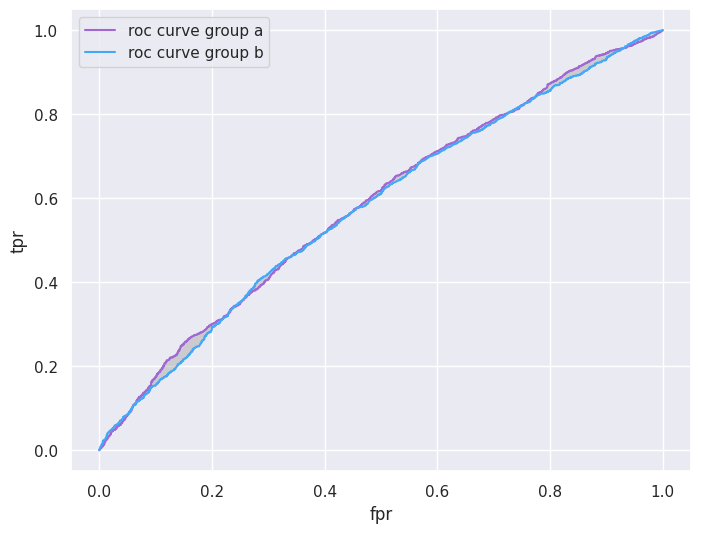


Disability
ABROCA value: 0.022353864463591777
Average Odds Difference value: 0.126965699016538
Equal Opportunity Difference value: 0.14801375501611536


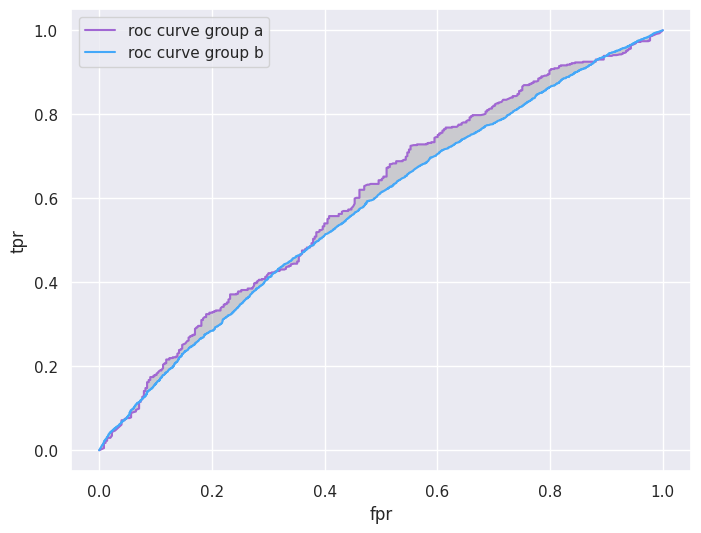


Age
ABROCA value: 0.009146827110555256
Average Odds Difference value: -0.11483072366529423
Equal Opportunity Difference value: -0.10445218365505127


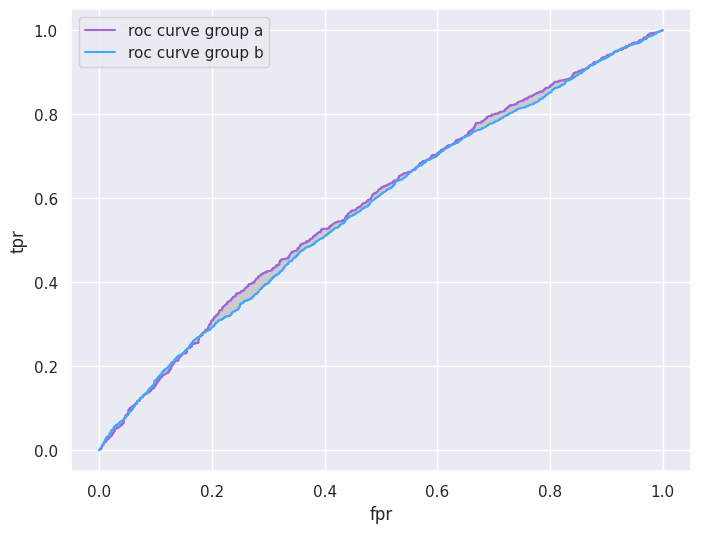

In [ ]:
# print the results for Random Forest
print('Random Forest accuracy:', RF_score)
print('\nGender')
compute_fairness2('gender')
print(f'\nDisability')
compute_fairness2('disability')
print(f'\nAge')
compute_fairness2('age_band')

## 2. VLE Dataset

In [ ]:
def compute_fairness_vp(data, sensitive_feature, y_pred, y_score, y_test):
  # Group data by sensitive feature
  group_a = (data[sensitive_feature] == 1).values
  group_b = (data[sensitive_feature] == 0).values

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, y_score, y_test)
  print(f'{sensitive_feature} ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred, y_test)
  print(f'{sensitive_feature} Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred, y_test)
  print(f'{sensitive_feature} Equal Opportunity Difference value: {eod_value}')

  fig, ax = plt.subplots(figsize=(6, 4))
  abroca_plot(group_a, group_b, y_score, y_test, ax=ax, title='ABROCA Plot')
  plt.show()

Logistic Regression accuracy: 0.7337901411331561

gender ABROCA value: 0.004678254430694584
gender Average Odds Difference value: -0.10231143901905518
gender Equal Opportunity Difference value: -0.05106402123543441


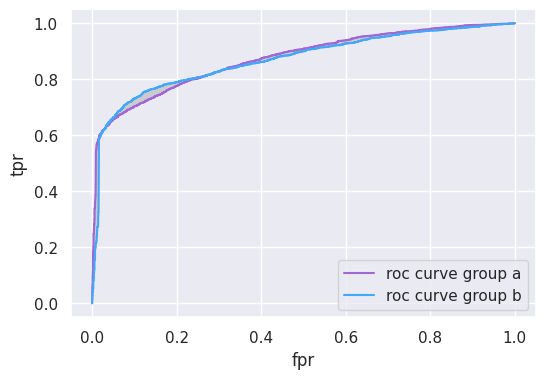


age_band ABROCA value: 0.0015913606710679096
age_band Average Odds Difference value: -0.07203486247599955
age_band Equal Opportunity Difference value: -0.03010295161924592


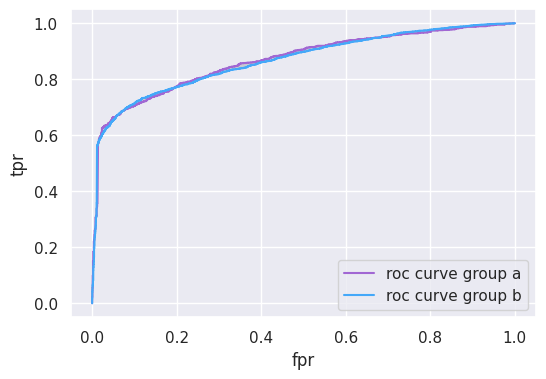


disability ABROCA value: -0.024833860530187102
disability Average Odds Difference value: 0.038449817983463336
disability Equal Opportunity Difference value: 0.011434160922752512


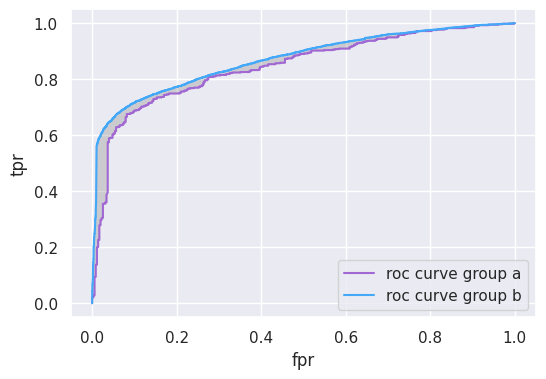

In [ ]:
# Create a DataFrame only for the sensitive features
sensitive_features = df_vle[['gender', 'age_band', 'disability']]

# Split your data into training and test sets, keeping track of the indices
from sklearn.model_selection import train_test_split

X = df_vle.drop(columns=['final_result', 'gender', 'age_band', 'disability'])
y = df_vle['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

# Train your model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8104929433421968

gender ABROCA value: 0.0011255631306668068
gender Average Odds Difference value: -0.03467911751405996
gender Equal Opportunity Difference value: -0.039442229380142635


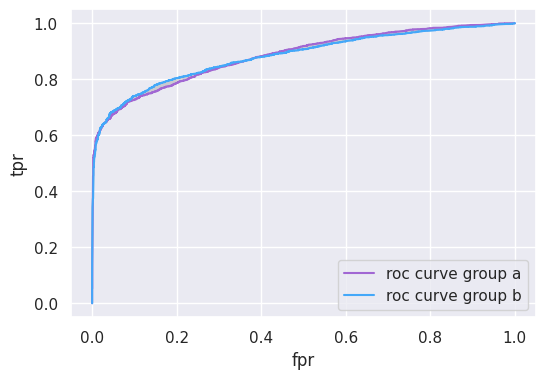


age_band ABROCA value: 0.006276398783959136
age_band Average Odds Difference value: -0.012767611197743743
age_band Equal Opportunity Difference value: -0.011663512199630133


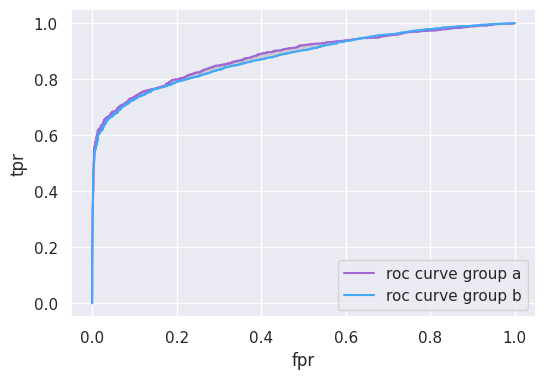


disability ABROCA value: -0.016324884144276464
disability Average Odds Difference value: 0.022605840160036396
disability Equal Opportunity Difference value: 0.01657938144956239


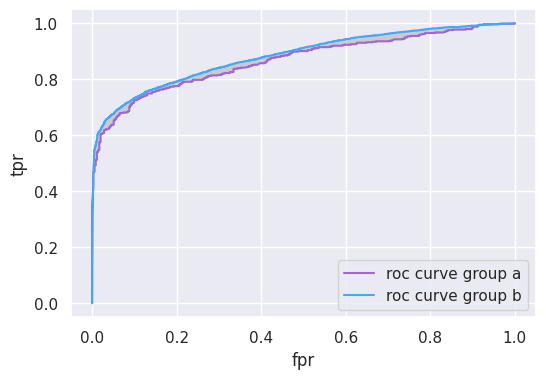

In [ ]:
# Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.7974023317651872

gender ABROCA value: 0.0016894712777333343
gender Average Odds Difference value: -0.026223322472437582
gender Equal Opportunity Difference value: -0.025497051917621527


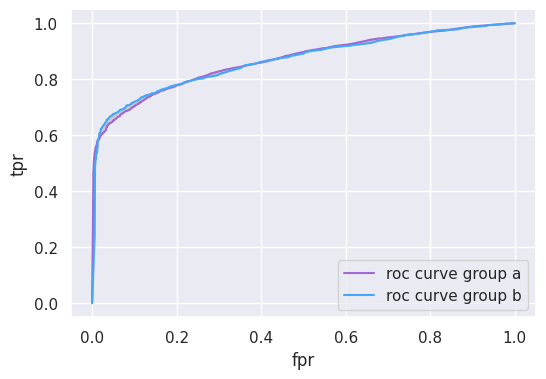


age_band ABROCA value: 0.00977224371224783
age_band Average Odds Difference value: -0.032113154817714026
age_band Equal Opportunity Difference value: -0.015331181317256415


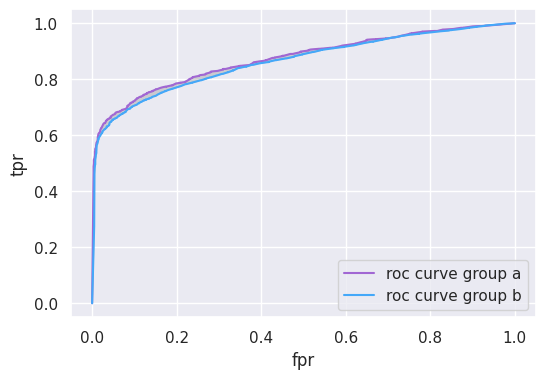


disability ABROCA value: -0.013281430448396137
disability Average Odds Difference value: 0.01815004779624979
disability Equal Opportunity Difference value: 0.013732232851036863


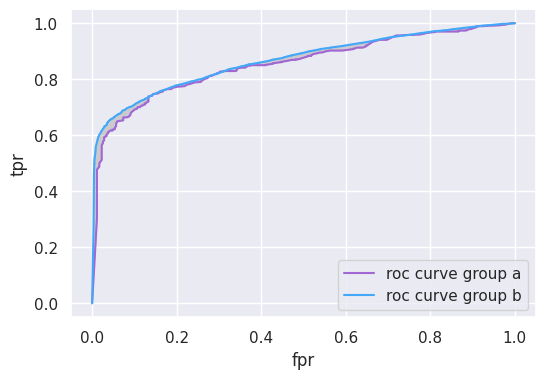

In [ ]:
# Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)

### 3. Performance Dataset

Logistic Regression accuracy: 0.7877889138883207

gender ABROCA value: 0.010313245910220203
gender Average Odds Difference value: -0.08404089328530676
gender Equal Opportunity Difference value: -0.052959694746710584


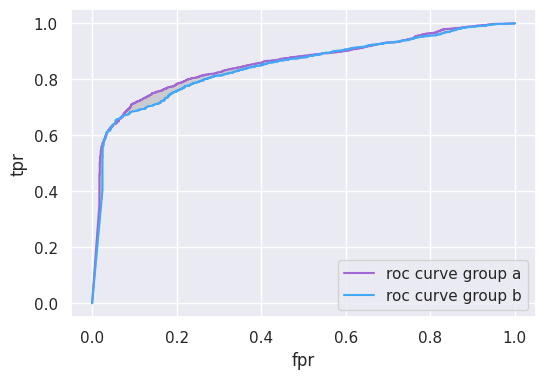


age_band ABROCA value: -0.002415333371982964
age_band Average Odds Difference value: 0.021293802230721998
age_band Equal Opportunity Difference value: 0.013095423335134582


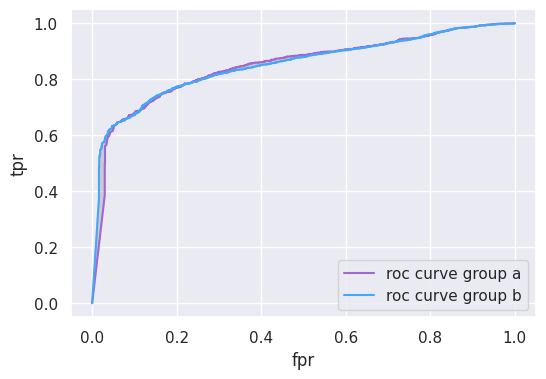


disability ABROCA value: 0.006058522243201359
disability Average Odds Difference value: 0.045608443832462736
disability Equal Opportunity Difference value: 0.04508504233130506


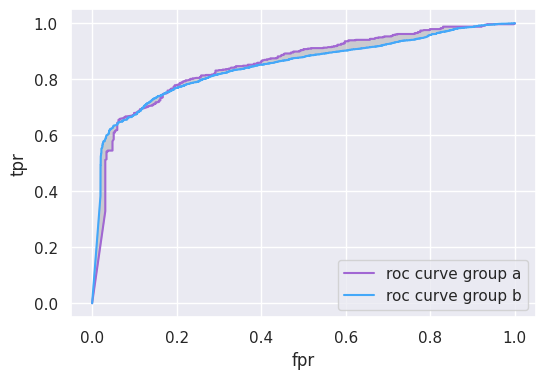

In [ ]:
# Create a DataFrame only for the sensitive features
sensitive_features = df_perf[['gender', 'age_band', 'disability']]

# Split your data into training and test sets, keeping track of the indices
from sklearn.model_selection import train_test_split

X = df_perf.drop(columns=['final_result', 'gender', 'age_band', 'disability'])
y = df_perf['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

# Train your model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8176518715483739

gender ABROCA value: 0.008262582112625871
gender Average Odds Difference value: -0.012270897491524851
gender Equal Opportunity Difference value: -0.011899029546485362


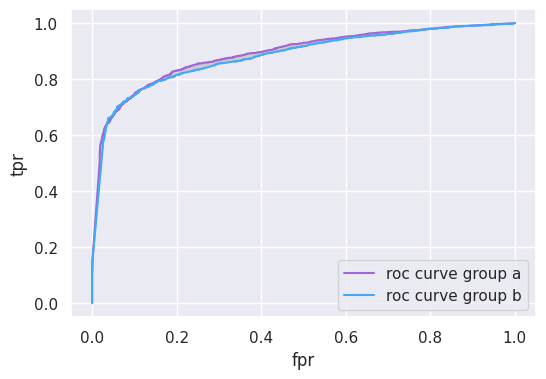


age_band ABROCA value: 0.005602635804841105
age_band Average Odds Difference value: 0.012411021306019218
age_band Equal Opportunity Difference value: 0.02248545597373075


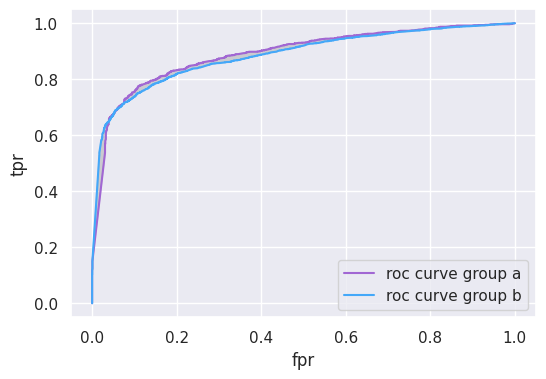


disability ABROCA value: 0.010502821396519701
disability Average Odds Difference value: 0.03200797333500276
disability Equal Opportunity Difference value: 0.05227316222595535


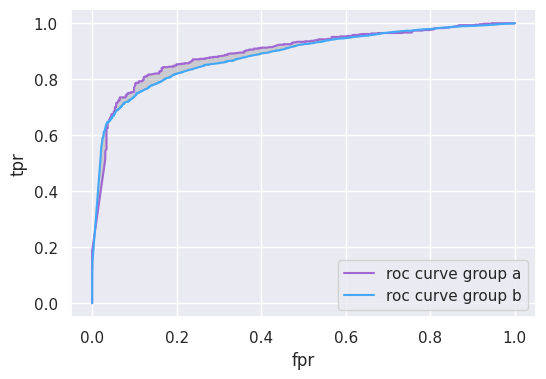

In [ ]:
# Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.7988341174064226

gender ABROCA value: -0.0005726489907909027
gender Average Odds Difference value: 0.0015519425656011637
gender Equal Opportunity Difference value: -0.007896106391179991


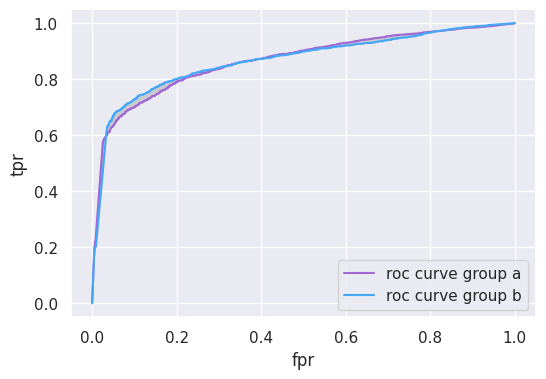


age_band ABROCA value: 0.005665740604923419
age_band Average Odds Difference value: 0.010088344058261131
age_band Equal Opportunity Difference value: 0.017947172814812506


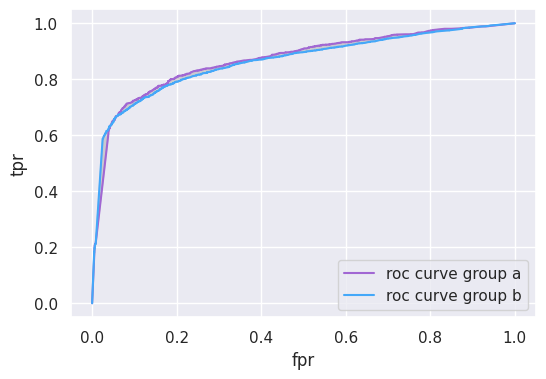


disability ABROCA value: 0.018677918306571728
disability Average Odds Difference value: 0.04436194196147
disability Equal Opportunity Difference value: 0.05071250861966836


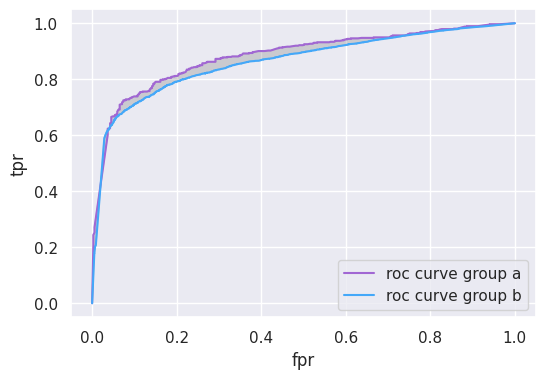

In [ ]:
# Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)

### 4. VLE + Performance Data

In [ ]:
# Create a DataFrame only for the sensitive features
sensitive_features = df_vle[['gender', 'age_band', 'disability']]

df_vle_perf = df[['gender', 'age_band', 'disability', 'sum_interaction_30', 'sum_interaction_60', 'sum_interaction_90',
                  'sum_interaction_120', 'score_tma1', 'score_tma2', 'score_tma3', 'score_tma4', 'final_result']]

# Define your features and target variable
X = df_vle_perf.drop(columns=['final_result', 'gender', 'age_band', 'disability'])
y = df_vle_perf['final_result']

In [ ]:
# Split your data into training and test sets, keeping track of the indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

Logistic Regression accuracy: 0.7933115156473717

gender ABROCA value: 0.016131105514497923
gender Average Odds Difference value: -0.100610499857967
gender Equal Opportunity Difference value: -0.05392729076762015


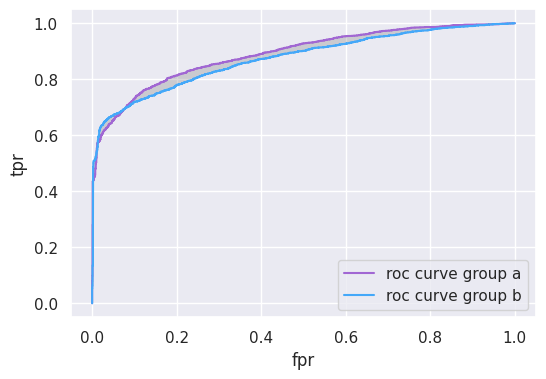


age_band ABROCA value: 0.002127801074507607
age_band Average Odds Difference value: -0.0136446943122564
age_band Equal Opportunity Difference value: -0.0075197967561329015


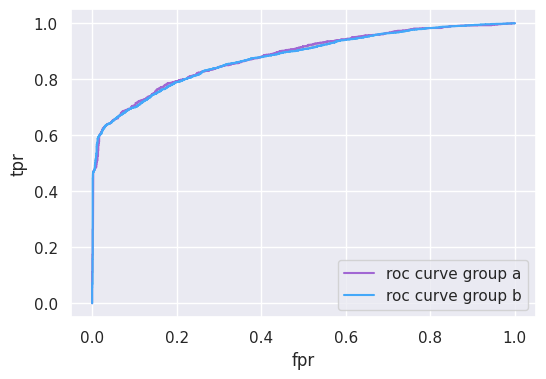


disability ABROCA value: -0.0009557398882868995
disability Average Odds Difference value: 0.04595389764825278
disability Equal Opportunity Difference value: 0.022609352074340228


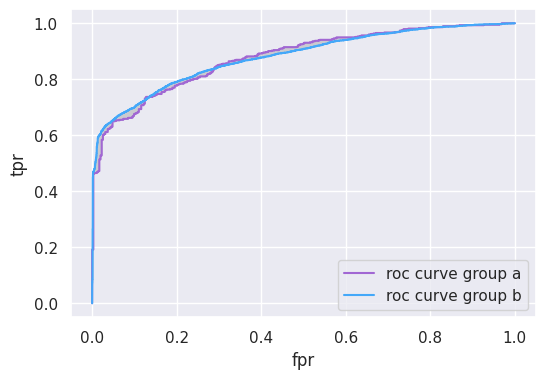

In [ ]:
# Train your model
lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8476170996113724

gender ABROCA value: 0.007564995518404505
gender Average Odds Difference value: -0.020312951081126795
gender Equal Opportunity Difference value: -0.014696637520230427


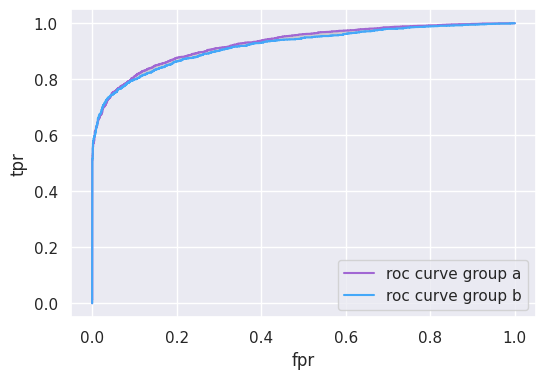


age_band ABROCA value: 0.009068427910013499
age_band Average Odds Difference value: -0.012780803274908957
age_band Equal Opportunity Difference value: -0.0022612200478875355


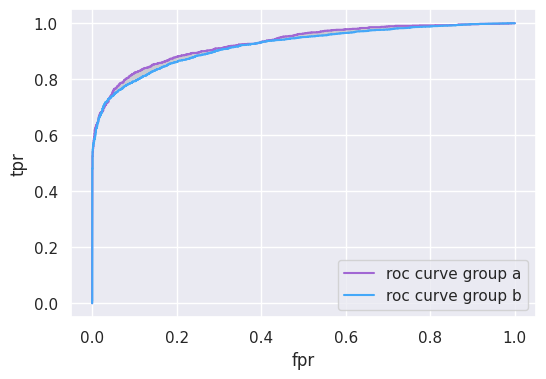


disability ABROCA value: 0.010793433797274932
disability Average Odds Difference value: 0.04383678445105355
disability Equal Opportunity Difference value: 0.05005559116495384


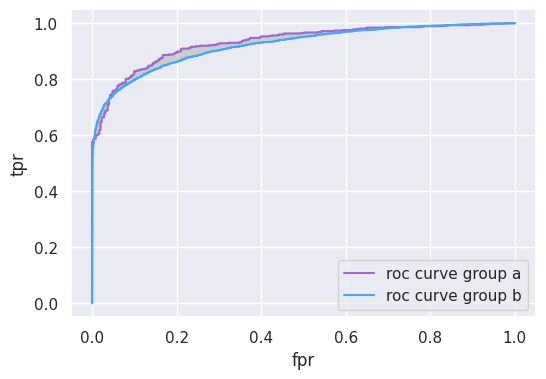

In [ ]:
# Train your model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.8465943955819186

gender ABROCA value: 0.0031712866110551463
gender Average Odds Difference value: -0.015781717059706483
gender Equal Opportunity Difference value: -0.0048480117315318205


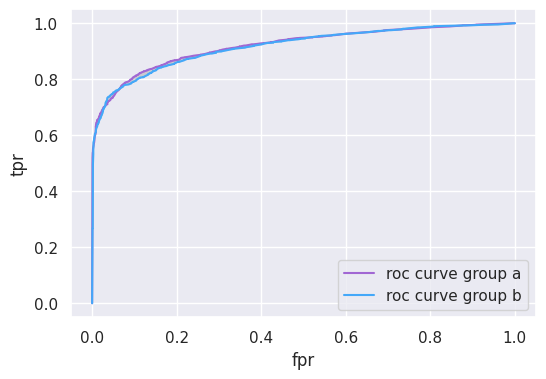


age_band ABROCA value: 0.008438349584160787
age_band Average Odds Difference value: -0.01912180193139606
age_band Equal Opportunity Difference value: -0.007579396850813991


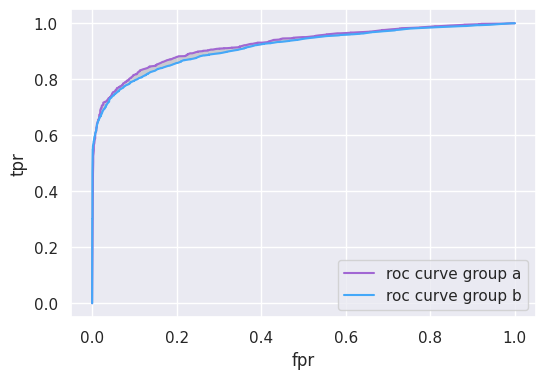


disability ABROCA value: 0.008532038699131661
disability Average Odds Difference value: 0.03733488852690966
disability Equal Opportunity Difference value: 0.034580438593027174


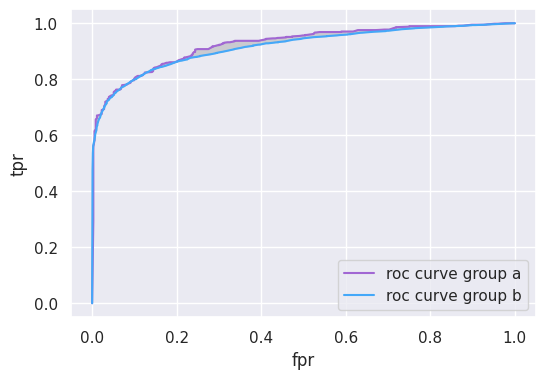

In [ ]:
# Train your model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)

### Institutional Data + VLE

Logistic Regression accuracy: 0.7631417467784823

gender ABROCA value: 0.022911323711175213
gender Average Odds Difference value: 0.008527707194313783
gender Equal Opportunity Difference value: 0.017633776305661875


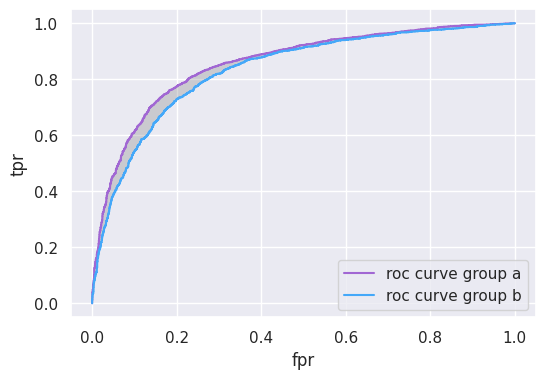


age_band ABROCA value: 0.014165202467790627
age_band Average Odds Difference value: -0.07431375226270942
age_band Equal Opportunity Difference value: -0.03736246948088506


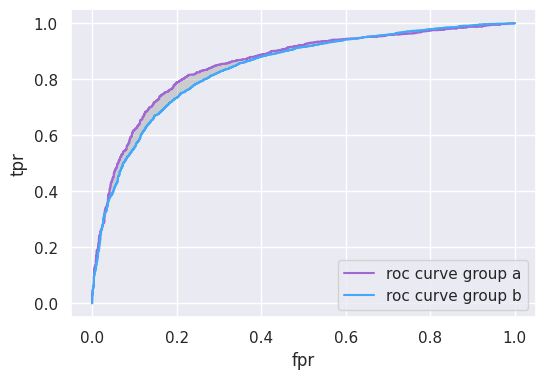


disability ABROCA value: -0.0026789727168401445
disability Average Odds Difference value: 0.0963933269207207
disability Equal Opportunity Difference value: 0.04498479596827354


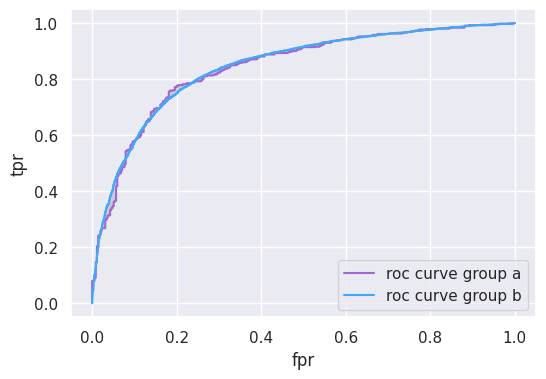

In [ ]:
# Create a DataFrame for the VLE + Institutional features
df_vle_inst = df[['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
                  'Reg_East Anglian Region', 'Reg_East Midlands Region', 'Reg_Ireland', 'Reg_London Region',
                  'Reg_North Region', 'Reg_North Western Region', 'Reg_Scotland', 'Reg_South East Region',
                  'Reg_South Region', 'Reg_South West Region', 'Reg_Wales', 'Reg_West Midlands Region',
                  'Reg_Yorkshire Region', 'Edu_A Level or Equivalent', 'Edu_HE Qualification', 'Edu_Lower Than A Level',
                  'Edu_No Formal quals','Edu_Post Graduate Qualification',
                  'sum_interaction_30', 'sum_interaction_60', 'sum_interaction_90', 'sum_interaction_120', 'final_result']]

# Create a DataFrame only for the sensitive features
sensitive_features = df_vle_inst[['gender', 'age_band', 'disability']]

# Split your data into training and test sets, keeping track of the indices
from sklearn.model_selection import train_test_split

X = df_vle_inst.drop(columns=['final_result'])
y = df_vle_inst['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

# Train your model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8163223563100839

gender ABROCA value: 0.0006346986791999631
gender Average Odds Difference value: 0.007526352993327483
gender Equal Opportunity Difference value: 0.0037949948869101524


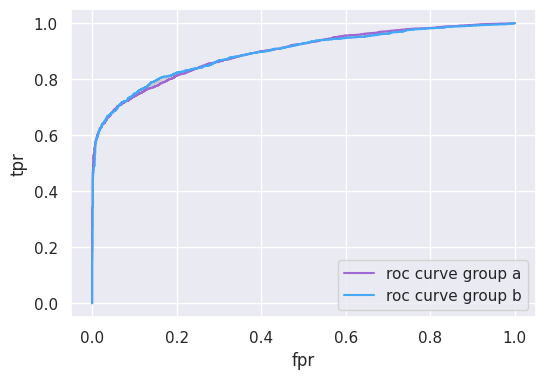


age_band ABROCA value: 0.005853930344758007
age_band Average Odds Difference value: -0.020570686945654997
age_band Equal Opportunity Difference value: -0.011327978755206747


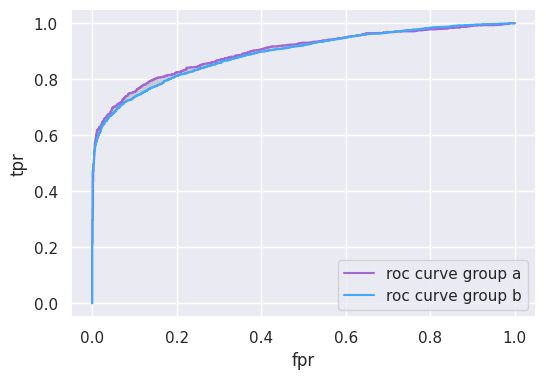


disability ABROCA value: -0.0017309110731165145
disability Average Odds Difference value: 0.05248934800539132
disability Equal Opportunity Difference value: 0.03856295319709957


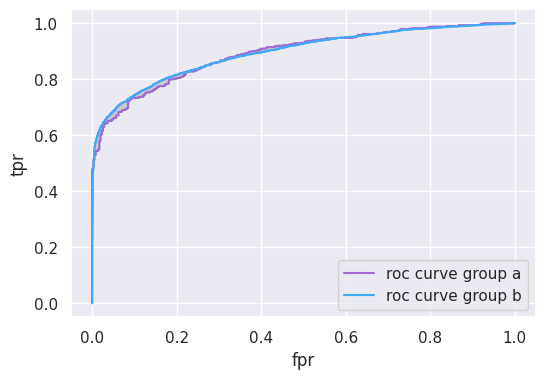

In [ ]:
# Train your model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.8115156473716506

gender ABROCA value: -0.002617629728868698
gender Average Odds Difference value: 0.0006244290246789352
gender Equal Opportunity Difference value: -0.007888506673767837


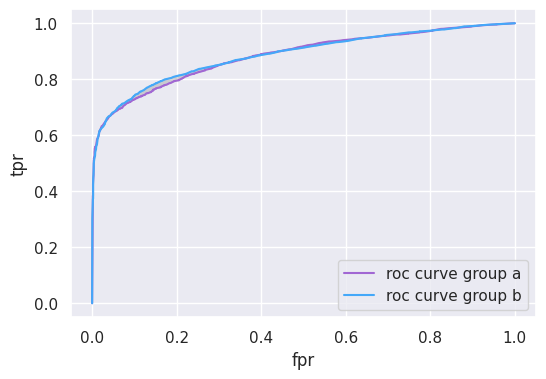


age_band ABROCA value: 0.01376587007910568
age_band Average Odds Difference value: -0.03510556229891091
age_band Equal Opportunity Difference value: -0.019364183926646628


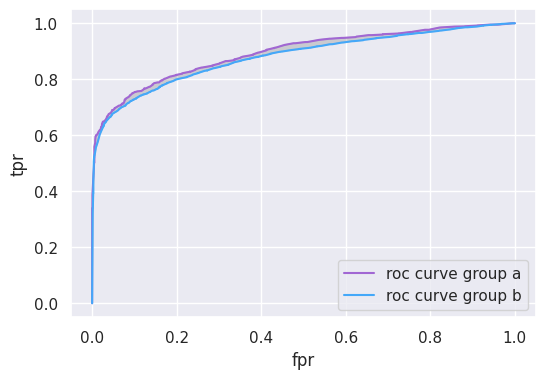


disability ABROCA value: -0.006312172934253568
disability Average Odds Difference value: 0.039385604941330705
disability Equal Opportunity Difference value: 0.023308798289128796


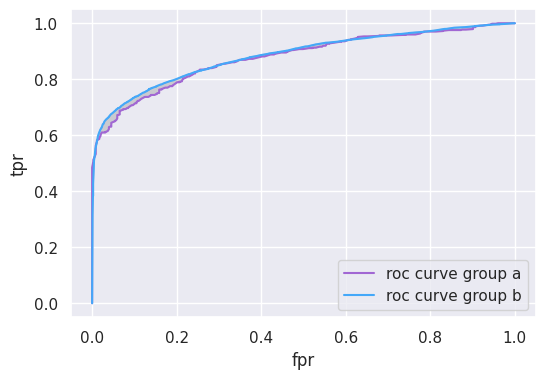

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train your model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)

### 6. Institutional + Performance Data

Logistic Regression accuracy: 0.7861525874411945

gender ABROCA value: 0.0018975032441920225
gender Average Odds Difference value: -0.018070982091027338
gender Equal Opportunity Difference value: -0.0030973408284786785


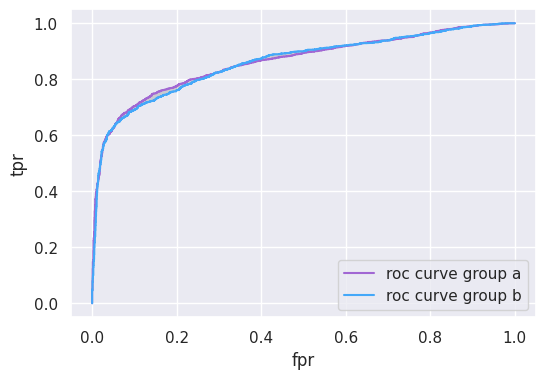


age_band ABROCA value: 0.0037576848048844758
age_band Average Odds Difference value: -0.021263315608941527
age_band Equal Opportunity Difference value: -0.010656911866359975


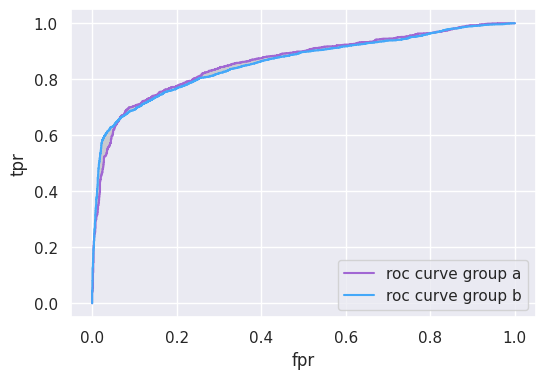


disability ABROCA value: 0.011218079738519848
disability Average Odds Difference value: 0.08209179033406726
disability Equal Opportunity Difference value: 0.06292889495092491


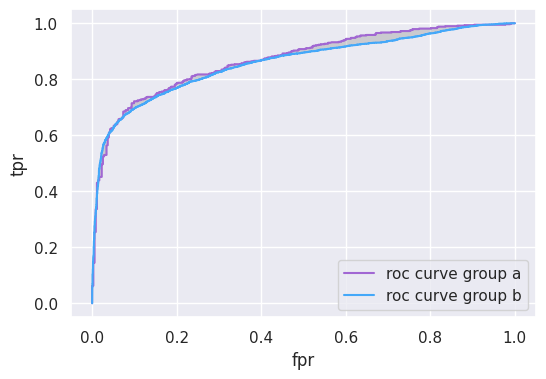

In [ ]:
# Define the data
df_inst_perf = df[['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
                         'Reg_East Anglian Region', 'Reg_East Midlands Region', 'Reg_Ireland', 'Reg_London Region',
                         'Reg_North Region', 'Reg_North Western Region', 'Reg_Scotland', 'Reg_South East Region',
                         'Reg_South Region', 'Reg_South West Region', 'Reg_Wales', 'Reg_West Midlands Region',
                         'Reg_Yorkshire Region', 'Edu_A Level or Equivalent', 'Edu_HE Qualification', 'Edu_Lower Than A Level',
                         'Edu_No Formal quals','Edu_Post Graduate Qualification',
                         'score_tma1', 'score_tma2', 'score_tma3', 'score_tma4', 'final_result']]

# Create a DataFrame only for the sensitive features
sensitive_features = df_inst_perf[['gender', 'age_band', 'disability']]

# Split your data into training and test sets, keeping track of the indices
X = df_inst_perf.drop(columns=['final_result'])
y = df_inst_perf['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

# Train your model
lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8177541419513192

gender ABROCA value: 0.0013705513324451246
gender Average Odds Difference value: 0.0022485100668095115
gender Equal Opportunity Difference value: 0.004313903591808832


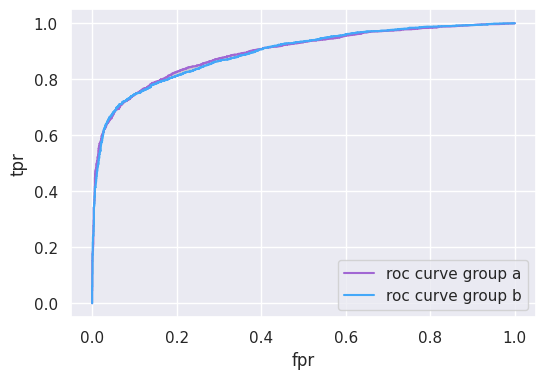


age_band ABROCA value: 0.006138222846022279
age_band Average Odds Difference value: -0.01780154685218755
age_band Equal Opportunity Difference value: -0.009104857502020502


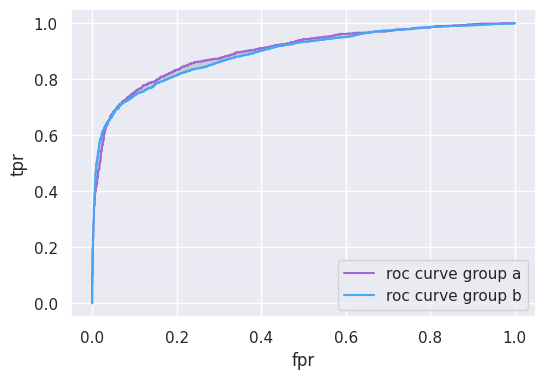


disability ABROCA value: 0.013208204937374624
disability Average Odds Difference value: 0.05723591182649652
disability Equal Opportunity Difference value: 0.07055749128919864


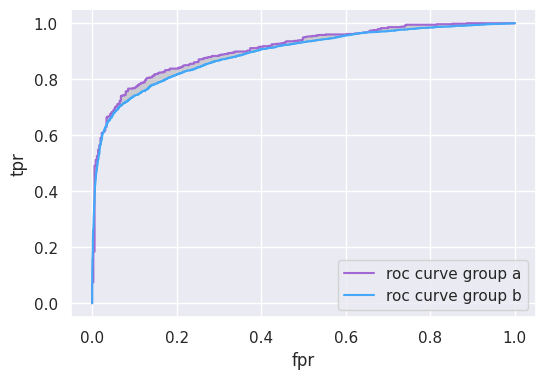

In [ ]:
# Train your model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.8058907752096544

gender ABROCA value: -0.00701428918638114
gender Average Odds Difference value: 0.005584629720265036
gender Equal Opportunity Difference value: -0.0028365185268951487


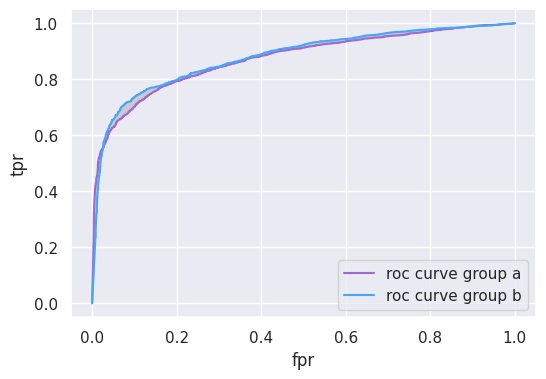


age_band ABROCA value: 0.006901908047508565
age_band Average Odds Difference value: -0.027880594274731427
age_band Equal Opportunity Difference value: -0.018208583356673635


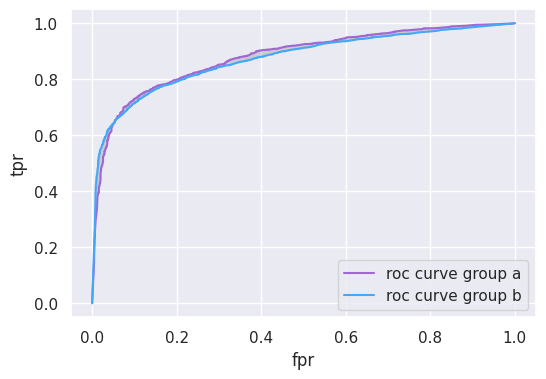


disability ABROCA value: 0.012351398916832568
disability Average Odds Difference value: 0.05200511124863852
disability Equal Opportunity Difference value: 0.05443149679971071


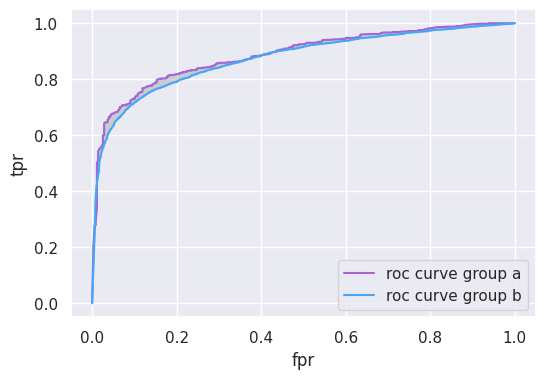

In [ ]:
# Train your model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)

### Institutional + VLE + Performance Data

Logistic Regression accuracy: 0.8027203927183473

gender ABROCA value: 0.01082952650946778
gender Average Odds Difference value: -0.001414421390541501
gender Equal Opportunity Difference value: 0.014157665561363775


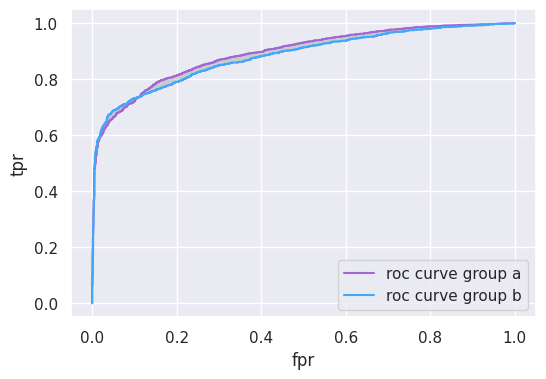


age_band ABROCA value: 0.004541065477248085
age_band Average Odds Difference value: -0.028718287301994452
age_band Equal Opportunity Difference value: -0.017804396638630093


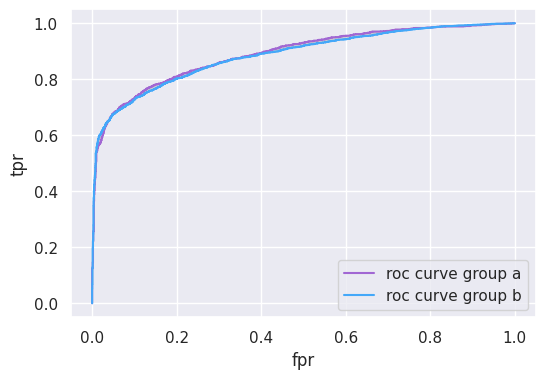


disability ABROCA value: 0.006220836957029574
disability Average Odds Difference value: 0.06530913961292302
disability Equal Opportunity Difference value: 0.05505803656865815


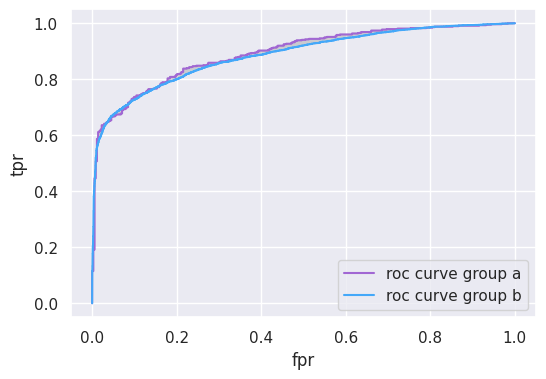

In [ ]:
df_all = df[['gender', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
            'Reg_East Anglian Region', 'Reg_East Midlands Region', 'Reg_Ireland', 'Reg_London Region',
            'Reg_North Region', 'Reg_North Western Region', 'Reg_Scotland', 'Reg_South East Region',
            'Reg_South Region', 'Reg_South West Region', 'Reg_Wales', 'Reg_West Midlands Region',
            'Reg_Yorkshire Region', 'Edu_A Level or Equivalent', 'Edu_HE Qualification', 'Edu_Lower Than A Level',
            'Edu_No Formal quals','Edu_Post Graduate Qualification',
            'sum_interaction_30', 'sum_interaction_60', 'sum_interaction_90', 'sum_interaction_120',
            'score_tma1', 'score_tma2', 'score_tma3', 'score_tma4', 'final_result']]

# Create a DataFrame only for the sensitive features
sensitive_features = df_all[['gender', 'age_band', 'disability']]

# Split your data into training and test sets, keeping track of the indices
from sklearn.model_selection import train_test_split

X = df_all.drop(columns=['final_result'])
y = df_all['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Keep track of the indices of the training and test sets
train_indices = X_train.index
test_indices = X_test.index

# Define sensitive feature for the training and test sets based on the indices
train_sensitive = sensitive_features.iloc[train_indices]
test_sensitive = sensitive_features.iloc[test_indices]

# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=3000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Make predicted probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_lr, y_score_lr, y_test)

Gradient Boosting accuracy: 0.8499693188791164

gender ABROCA value: 0.004609185633808077
gender Average Odds Difference value: -0.0033543148183550683
gender Equal Opportunity Difference value: -0.0011855559162887719


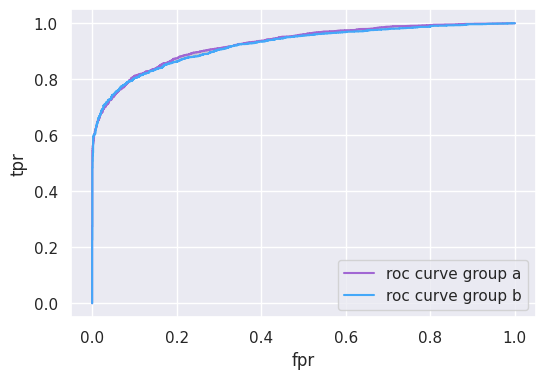


age_band ABROCA value: 0.009054226840091495
age_band Average Odds Difference value: -0.020667209930640286
age_band Equal Opportunity Difference value: -0.011256119147379229


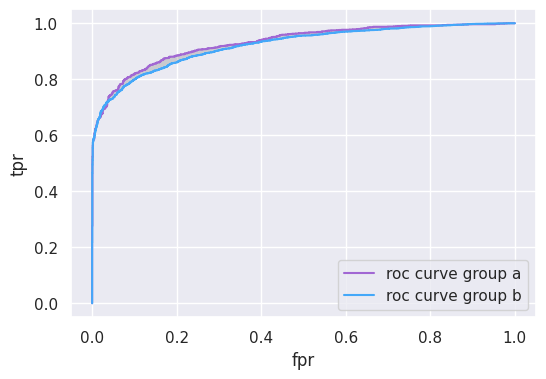


disability ABROCA value: 0.011774032238052956
disability Average Odds Difference value: 0.05319289372121208
disability Equal Opportunity Difference value: 0.060720437195653565


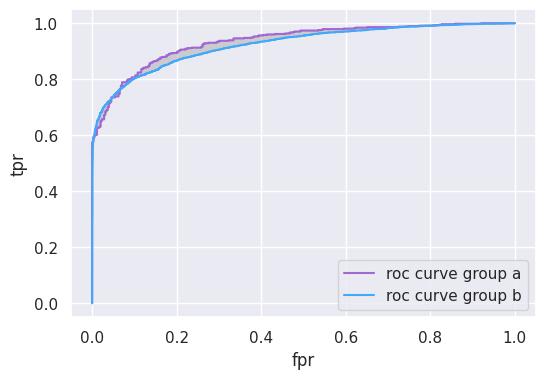

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Make predicted probabilities
y_score_gb = gb.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Gradient Boosting accuracy: {accuracy_score(y_test, y_pred_gb)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_gb, y_score_gb, y_test)

Random Forest accuracy: 0.8472080179995909

gender ABROCA value: 0.0006022395166463967
gender Average Odds Difference value: -0.0016827578950899744
gender Equal Opportunity Difference value: -0.0013606534054637631


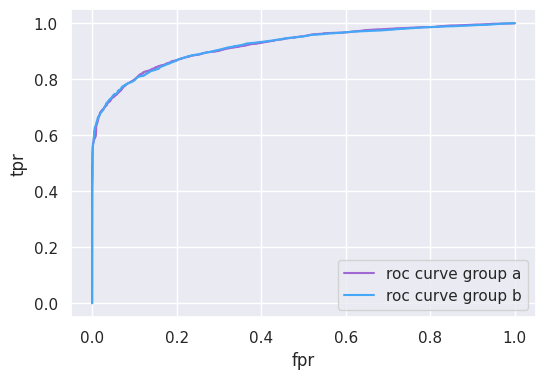


age_band ABROCA value: 0.011367291459649098
age_band Average Odds Difference value: -0.01971758080698177
age_band Equal Opportunity Difference value: -0.009338731291275715


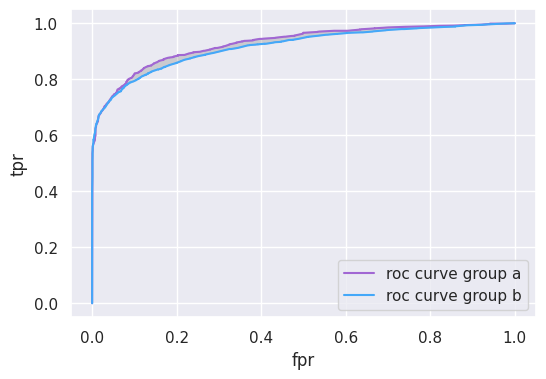


disability ABROCA value: 0.011753455896129195
disability Average Odds Difference value: 0.053397719203241295
disability Equal Opportunity Difference value: 0.04808483880081049


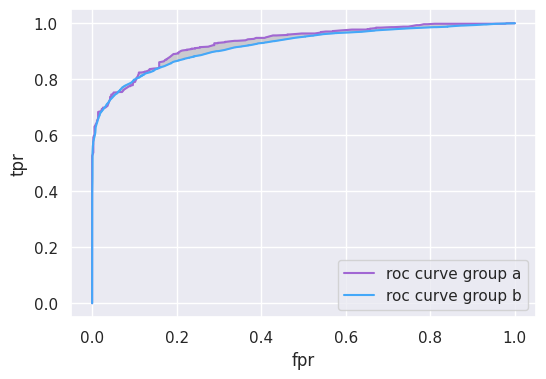

In [ ]:
# Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Make predicted probabilities
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Print out accuracy
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred_rf)}')

# Compute fairness for each sensitive feature
for feature in ['gender', 'age_band', 'disability']:
  print()
  compute_fairness_vp(test_sensitive, feature, y_pred_rf, y_score_rf, y_test)